In [1]:
# Mount Google Drive (If using Colab)

from google.colab import drive
drive.mount("drive")

Mounted at drive


In [2]:
# Install Required Libraries from PyPI

!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
!pip install tqdm

  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to /tmp/pip-req-build-d89jb3_u
  Running command git clone -q https://github.com/hukkelas/DSFD-Pytorch-Inference.git /tmp/pip-req-build-d89jb3_u
  Created wheel for face-detection: filename=face_detection-0.2.1-py3-none-any.whl size=29730 sha256=43731e213f223ea99b1690a15366811885cf3b2381ae7e29dfe3866f4783bf24
  Stored in directory: /tmp/pip-ephem-wheel-cache-jn0i73rl/wheels/11/5d/8c/04ffb7a0ca5427f3e674703ea75ecb16542e94efcc46d6bc1b
Successfully built face-detection


In [3]:
# Import Required Libraries

import os
import numpy as np
import cv2
import face_detection
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.layers import Dense,Dropout,AveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm, tqdm_notebook
from google.colab.patches import cv2_imshow

In [4]:
# Initialize a Face Detector 
# Confidence Threshold can be Adjusted, Greater values would Detect only Clear Faces

detector = face_detection.build_detector("DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

Downloading: "https://folk.ntnu.no/haakohu/WIDERFace_DSFD_RES152.pth" to /root/.cache/torch/hub/checkpoints/WIDERFace_DSFD_RES152.pth


  0%|          | 0.00/459M [00:00<?, ?B/s]

## BLURRING AUGMENTATION ##

In [5]:
# Define Blurring Kernel Size Ranges, a Random Size would be chosen in the Specified Ranges
# Greater the Size, Higher is the Blurring Effect (Adjustments can be made according to the needs)

motion_blur_kernel_range = (4,8)  
average_blur_kernel_range = (3,7)
gaussian_blur_kernel_range = (3,8)

In [6]:
# Set Blurring Kernels to Use and their associated Probabilities

Blurring_Kernels = ["none","motion","gaussian","average"]
Probs = [0.75,0.1,0.05,0.1]

In [7]:
# Add Motion Blur to an Image in a Random Direction

def motion_blur(img):

  # Choose a Random Kernel Size
  kernel_size = np.random.randint(motion_blur_kernel_range[0],motion_blur_kernel_range[1])
  kernel = np.zeros((kernel_size, kernel_size))

  # Random Selection of Direction of Motion Blur
  types = ["vertical","horizontal","main_diagonal","anti_diagonal"]
  choice = np.random.choice(types)

  if choice=="vertical":
    kernel[:,int((kernel_size-1)/2)] = np.ones(kernel_size)/kernel_size
  
  elif choice=="horizontal":
    kernel[int((kernel_size-1)/2),:] = np.ones(kernel_size)/kernel_size
  
  elif choice=="main_diagonal":
    
    for i in range(kernel_size):
      kernel[i][i] = 1/kernel_size

  elif choice=="anti_diagonal":

    for i in range(kernel_size):
      kernel[i][kernel_size-i-1] = 1/kernel_size

  # Convolve and Return the Blurred Image
  return cv2.filter2D(img,-1,kernel)

In [8]:
# Add a Random Blur Effect to an Image with a Random Kernel Size (in the Specified Ranges)

def get_blurred_picture(img):
  
  # Randomly choose a Blurring Technique
  choice = np.random.choice(Blurring_Kernels,p=Probs)

  # RGB to BGR for OpenCV
  img = img[:,:,::-1]

  if choice=="none":

    random_blurred_img = img

  elif choice=="motion":
  
    random_blurred_img  = motion_blur(img)

  elif choice=="gaussian":

    kernel_size = np.random.randint(gaussian_blur_kernel_range[0],gaussian_blur_kernel_range[1])

    if kernel_size%2==0:
      kernel_size-=1
    
    random_blurred_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

  elif choice=="average":
  
    kernel_size = np.random.randint(average_blur_kernel_range[0],average_blur_kernel_range[1])
    random_blurred_img = cv2.blur(img,(kernel_size,kernel_size))

  # PreProcess for ResNet50
  preprocessed = resnet50.preprocess_input(random_blurred_img[:,:,::-1])
  
  return preprocessed 

## TRAINING ##

In [9]:
# Load Pretrained ResNet50 Model (without Last few Layers) 
# Freeze all the Layers

base_network  = resnet50.ResNet50(input_shape = (224,224,3),weights='imagenet',include_top=False)
for layer in base_network.layers:
  layer.trainaibale = False

94781440/94765736 [==============================] - 1s 0us/step


In [10]:
# Define the Face Mask Classifier Model by adding a few Layers on top of the ResNet50 Pretrained Model

classifier_network = base_network.output
classifier_network = AveragePooling2D(pool_size=(7, 7),name = "Average_Pool_Final")(classifier_network)
classifier_network = Flatten(name = "Flatten_Final")(classifier_network)
classifier_network = Dense(128, activation="relu",name = "Dense_Final")(classifier_network)
classifier_network = Dropout(0.5,name = "Dropout_Final")(classifier_network)
classifier_network = Dense(1, activation="sigmoid", name = "Sigmoid_Classifier" )(classifier_network)

mask_classifier = Model(inputs=base_network.input, outputs=classifier_network)

In [11]:
mask_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
# Set Path to the Dataset
# Faces would be extracted and placed in the specified Directory after Processing

Dataset_PATH = "drive/My Drive/CoviWarn/Training_Data"
Processed_Dataset_PATH = "drive/My Drive/CoviWarn/Processed_Training_Data"

# Create Empty Directories
os.mkdir(Processed_Dataset_PATH)
os.mkdir(os.path.join(Processed_Dataset_PATH,"with_mask"))
os.mkdir(os.path.join(Processed_Dataset_PATH,"without_mask"))

In [13]:
# Prepare the Data for Training 
# Extract Faces from the Dataset and Save them in the specified Directory
from tqdm import tqdm, tqdm_notebook
# There should be 2 Sub-Directories corresponding to Masked and Non-Masked Faces
paths = ["with_mask","without_mask"]

for path in paths:

  curr_path = os.path.join(Dataset_PATH,path)
  
  # Loop through all Images
  for file_name in tqdm_notebook(os.listdir(curr_path)):

    try:
      
      image = cv2.imread(os.path.join(curr_path,file_name))

      # Detect Faces, Crop and Save
      detections = detector.detect(image[:,:,::-1])

      for j in range(len(detections)):
    
        face = image[int(detections[j][1]):int(detections[j][3]),
                     int(detections[j][0]):int(detections[j][2])]
        
        cv2.imwrite(os.path.join(Processed_Dataset_PATH,path)+"/"+file_name,face)
    
    except:
      continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/403 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/407 [00:00<?, ?it/s]

In [14]:
# Set the Hyper-Parameters

alpha = 0.00001
n_epochs = 5
mini_batch_size = 32

In [15]:
# Compile the Model

opt = Adam(learning_rate=alpha,decay = alpha/n_epochs)
mask_classifier.compile(optimizer=opt,loss="binary_crossentropy",metrics = ['accuracy'])

In [16]:
# Define a ImageDataGenerator for Real-Time Data Augmentation
# Parameters can be Tuned for controlling the Augmentation

Data_Generator = ImageDataGenerator(horizontal_flip=True,
                                    brightness_range=[0.5,1.25],
                                    zoom_range=[0.8,1],
                                    rotation_range = 15,
                                    preprocessing_function=get_blurred_picture)

In [17]:
# Create a Data_Generator Instance

Train_Data_Generator = Data_Generator.flow_from_directory(Processed_Dataset_PATH,target_size=(224,224),
                                                          class_mode="binary",batch_size=mini_batch_size)

Found 807 images belonging to 2 classes.


In [18]:
# Train the Model

history=mask_classifier.fit(x=Train_Data_Generator,
                    steps_per_epoch=(Train_Data_Generator.n//mini_batch_size),
                    epochs=n_epochs)

Epoch 1/5
25/25 [==============================] - 56s 754ms/step - loss: 0.5851 - accuracy: 0.7032
Epoch 2/5
25/25 [==============================] - 18s 718ms/step - loss: 0.2959 - accuracy: 0.8903
Epoch 3/5
25/25 [==============================] - 18s 718ms/step - loss: 0.1805 - accuracy: 0.9458
Epoch 4/5
25/25 [==============================] - 18s 718ms/step - loss: 0.1306 - accuracy: 0.9690
Epoch 5/5
25/25 [==============================] - 18s 715ms/step - loss: 0.1003 - accuracy: 0.9652


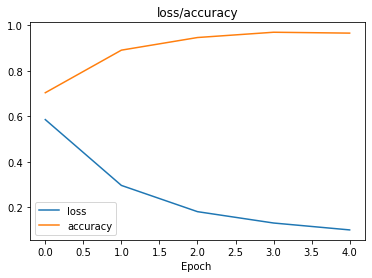

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.legend(['loss','accuracy'])
plt.title('loss/accuracy')
plt.xlabel('Epoch ')
plt.show()

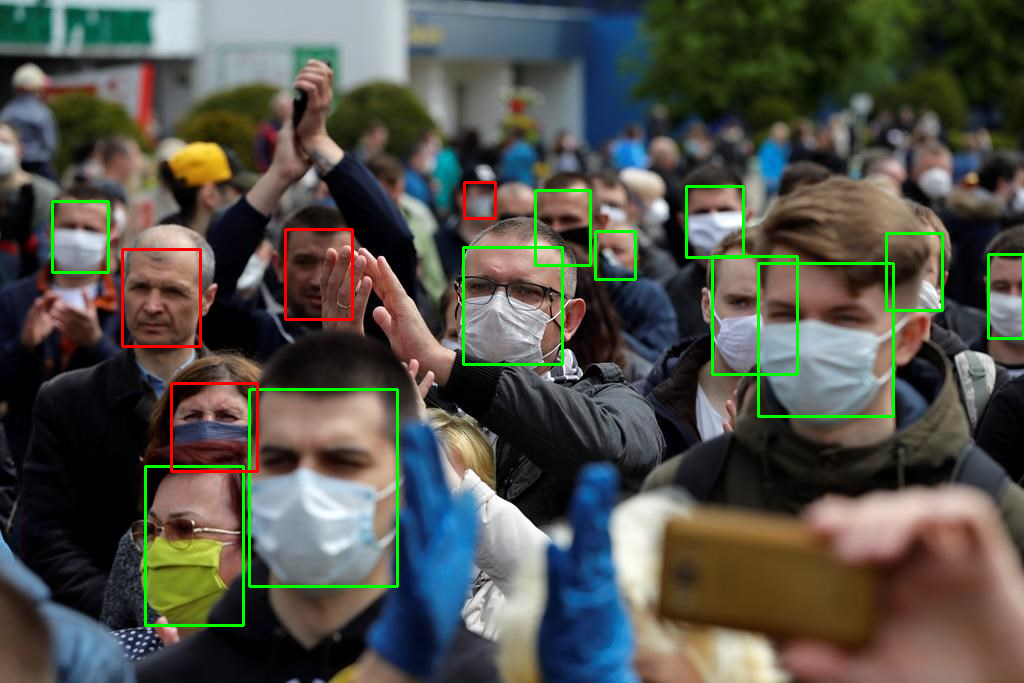

In [26]:
# Test the Model on a Picture

FILE_PATH = "drive/My Drive/CoviWarn/SampleCrowd2.jpg"

img = cv2.imread(FILE_PATH)
masked_faces = []
unmasked_faces = []

# Detect Faces
detections = detector.detect(img[:,:,::-1])

if detections.shape[0]>0:
      
  for i in range(detections.shape[0]):
  
    # Get Co-ordinates
    x1 = int(detections[i][0])
    x2 = int(detections[i][2])
    y1 = int(detections[i][1])
    y2 = int(detections[i][3])

    # Predict Output
    face_arr = cv2.resize(img[y1:y2,x1:x2,::-1], (224, 224), interpolation=cv2.INTER_NEAREST)
    face_arr = np.expand_dims(face_arr, axis=0)
    face_arr = resnet50.preprocess_input(face_arr)
    match = mask_classifier.predict(face_arr)

    if match[0][0]<0.5:
      masked_faces.append([x1,y1,x2,y2])
    else:
      unmasked_faces.append([x1,y1,x2,y2])

# Put Bounding Box on the Faces (Green:Masked,Red:Not-Masked)
for f in range(len(masked_faces)):

  a,b,c,d = masked_faces[f]
  cv2.rectangle(img, (a,b), (c,d), (0,255,0), 2)

for f in range(len(unmasked_faces)):

  a,b,c,d = unmasked_faces[f]
  cv2.rectangle(img, (a,b), (c,d), (0,0,255), 2)

# Show Results
cv2_imshow(img)

In [27]:
# Save the Trained Weights to Disk

SAVE_PATH = "drive/My Drive/CoviWarn/ResNet50_Classifier.h5"
mask_classifier.save(SAVE_PATH)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
